# Module - Preprocessing

In [1]:
# Import to be able to import python package from src
import sys
sys.path.insert(0, '../src')

In [2]:
import pandas as pd
import numpy as np
from darts.datasets import EnergyDataset

In [3]:
import ontime as on

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/Users/fred.montet/Library/Caches/pypoetry/virtualenvs/ontime-FpQu8-YN-py3.10/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


---
## Load data

In [4]:
ts = EnergyDataset().load()
ts = ts.astype(np.float32)

In [5]:
ts = ts.univariate_component(0)

<Axes: xlabel='time'>

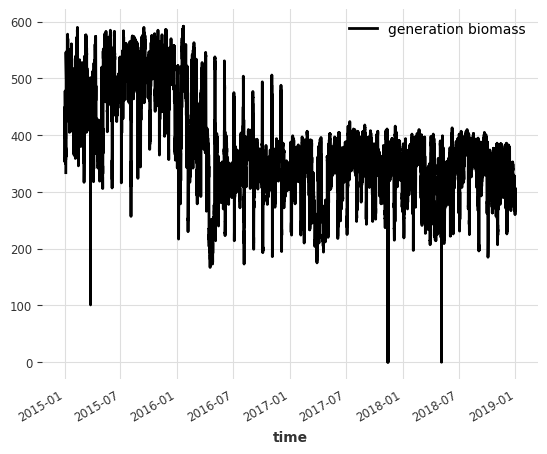

In [6]:
ts.plot()

In [7]:
from darts.dataprocessing.transformers import MissingValuesFiller

In [8]:
transformer = MissingValuesFiller()
ts = transformer.transform(ts)

---

## Tensorflow Preprocessing

In [9]:
from ontime.module import preprocessing

### Time series data

In [71]:
ts_t = preprocessing.common.normalize(ts)

train, test = preprocessing.common.train_test_split(ts_t, train_split=0.8)

train_list = preprocessing.common.split_by_length(train, 10, 10)
test_list = preprocessing.common.split_by_length(test, 10, 10)

X_train, y_train = preprocessing.common.split_inputs_from_targets(train_list, 9, 1)
X_test, y_test = preprocessing.common.split_inputs_from_targets(test_list, 9, 1)

X_train = preprocessing.common.timeseries_list_to_numpy(X_train)
y_train = preprocessing.common.timeseries_list_to_numpy(y_train)
X_test = preprocessing.common.timeseries_list_to_numpy(X_test)
y_test = preprocessing.common.timeseries_list_to_numpy(y_test)

In [72]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2805, 9, 1)
(2805, 1, 1)
(701, 9, 1)
(701, 1, 1)


In [73]:
X_train[0]

array([[0.7550676],
       [0.758446 ],
       [0.7567568],
       [0.7398649],
       [0.722973 ],
       [0.6925676],
       [0.6773649],
       [0.6891892],
       [0.6976352]], dtype=float32)

In [74]:
X_train[1]

array([[0.7128379],
       [0.7111487],
       [0.722973 ],
       [0.7179054],
       [0.7145271],
       [0.7111487],
       [0.7128379],
       [0.7195946],
       [0.7212838]], dtype=float32)

In [75]:
y_train[0]

array([[0.7077703]], dtype=float32)

## Modelling

In [76]:
input_shape = X_train[0].shape
output_shape = y_train[0].shape

In [78]:
import tensorflow as tf

In [79]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(units=1)
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(output_shape[0])
])

In [80]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

absl       WARNING At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


In [81]:
model.fit(
    X_train,
    y_train,
    epochs=4
)

Epoch 1/4
88/88 [==============================] - 0s 502us/step - loss: 0.0032 - mean_absolute_error: 0.0362
Epoch 2/4
88/88 [==============================] - 0s 355us/step - loss: 0.0016 - mean_absolute_error: 0.0238
Epoch 3/4
88/88 [==============================] - 0s 348us/step - loss: 0.0012 - mean_absolute_error: 0.0206
Epoch 4/4
88/88 [==============================] - 0s 377us/step - loss: 0.0011 - mean_absolute_error: 0.0190


In [82]:
model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 469us/step - loss: 6.8488e-04 - mean_absolute_error: 0.0155


[0.0006848822231404483, 0.015547183342278004]

In [83]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [84]:
y_pred = model.predict(X_test)

22/22 [==============================] - 0s 421us/step


In [85]:
y_pred.shape

(701, 1)

In [87]:
mape(y_pred, y_test[:,0])

0.028172426

In [88]:
import matplotlib.pyplot as plt

<Axes: >

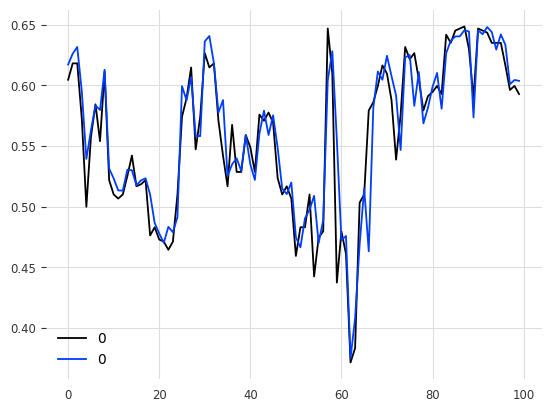

In [91]:
start = 500
width = 100

fig, ax = plt.subplots()
pd.DataFrame(y_test[:,0][start:start+width]).plot(ax=ax)
pd.DataFrame(y_pred[start:start+width]).plot(ax=ax)